In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter
from matplotlib import animation, rc
from IPython.display import HTML
mpl.rc('font',**{'size' : 16})

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter


In [2]:
basedir = '/home/lee/OneDrive/Data/TRMC/Refined/Freqdep/'

fps = {
    'KCs' :  basedir + 'KCs/',
    'PC' :  basedir + 'PC/',
    'SP' :  basedir + 'SP/'
}

# os.listdir(fps['SP'])

/home/lee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


(8420000000.0, 8652000000.0)

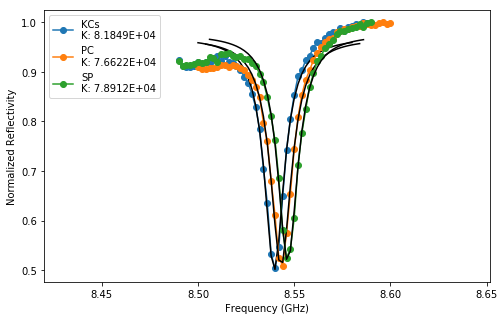

In [3]:
fps_sw = {}

fps_sw['KCs'] = fps['KCs'] + "Sweep_0ms_exp.csv"
fps_sw['PC'] = fps['PC'] + "Sweep_0ms_exp.csv"
fps_sw['SP'] = fps['SP'] + "Sweep_0ms_exp.csv"

swps = []
swps_V = []
maxV = {}

for samp in fps_sw:  
    if samp == 'KCs':
        df = pd.read_csv(fps_sw[samp],index_col=False)
        df = df.set_index(df['f(Ghz)'])
        swps.append(df['Experimental R'])
        swps_V.append(df[' Vsignal(V)'])
        maxV[samp] = df[' Vsignal(V)'].max()
    
    else:
        df = pd.read_csv(fps_sw[samp], index_col = 0, skiprows = 4)
        swps.append(df['Reflectivity'])
        maxV[samp] = 0.12
    
    
swps = dict(zip(fps_sw.keys(),swps))
swps_V = dict(zip(fps_sw.keys(),swps_V))

back_V_fit = {} #Forgot to copy values sometimes, so using the Vsignal max value and R0 to estimate background voltage
K = {}

fig, ax = plt.subplots(1,figsize = (8,5))
for sample in swps:
    sweep = swps[sample]
    
    p0 =[sweep.argmin(),1e7,.5 ,1]
    popt, sl = analysis.fit_lor(sweep, p0, window = 20)
    fit_func = analysis.lorfn(*popt)
    fit_func = fit_func(sweep.index.values)

#     fit_func, popt, sl = fit_poly(sweep, window = 3)

    K[sample] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2], printparams = False)
    back_V_fit[sample] = -maxV[sample]*popt[2]
    
    ax.plot(sweep, marker = 'o', label = (sample + "\nK: " + str("{:0.4E}".format(K[sample]))))
    ax.plot(sweep.index.values[sl],fit_func[sl] , color = 'black')
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('Normalized Reflectivity')
ax.legend()
ax.xaxis.get_offset_text().set_visible(False)
ax.set_xlim(8.42e9,8.652e9)

In [4]:
direc = os.path.join(fps['KCs'],'FreqFluence')
s_fps = load.freqfluence_flist(direc)
s,backvs = load.freqfluence_load(s_fps)


s1 = s.xs('U',level = 0).sort_index(level = 0)
fluences = s1.index.levels[1]
s2 = s1.xs(fluences[-1],level = 1).sort_index(level = 0)

s2 = s2.swaplevel(0,1).sort_index()

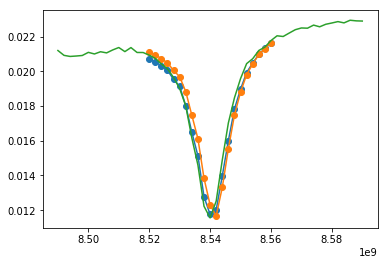

In [5]:
plt.plot(backvs.xs('U').sort_index(level = 1),marker = 'o')
plt.plot(backvs.xs('D').sort_index(level = 1),marker = 'o')
plt.plot(swps_V['KCs'])

(2e-07, 7e-07)

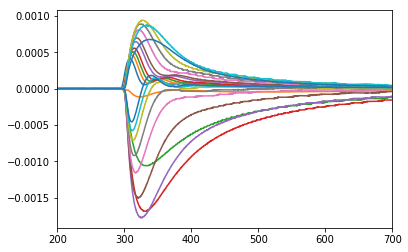

In [6]:
fig, ax = plt.subplots()

freqs = s2.index.levels[1]
for freq in freqs:
    ax.plot(s2[:,freq])
    
ax.xaxis.set_major_formatter(FuncFormatter(exp_formatter(-9).format_func))
ax.set_xlim([200e-9,700e-9])

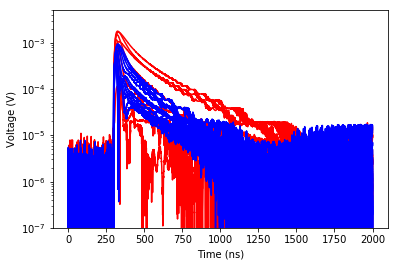

In [7]:
fig, ax = plot.absplot(s2)

(2.5e-07, 7e-07)

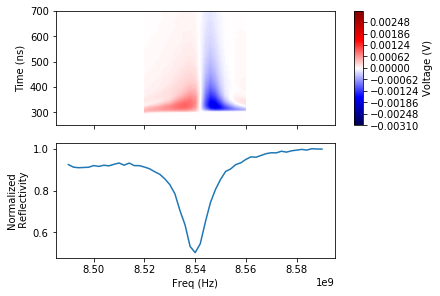

In [8]:
fig, axes = plot.dvcolorplot(swps['KCs'],s2,levels = list(np.arange(-3.1e-3,3.1e-3,1e-5)))

axes[0].set_ylim([2.5e-7,0.7e-6])


In [16]:
# params = np.zeros([len(s2_red.index.levels[0]),len(p_labels)])

v0 = backvs.xs('U').sort_index(level = 1)

s2_red = s2.loc[::10,:]
s2_red.index = s2_red.index.remove_unused_levels()


fits = s2_red.copy()
vss = s2_red.copy()
dvs = s2_red.copy()


fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    p0 =[v0.idxmin(),1e7,0.01, Rinf]
    p_labels = ['f0','Q','R','Rinf'] 
    epsilon = 0.00001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 7

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    
    
def fitsweep(v, p0, bounds, window, fittype, p_labels):
    if fittype == 'lor':
        
        
        v_p, v_sl = analysis.fit_lor(v, p0,bounds, window)
        v_fit = analysis.lorfn(*v_p)

    elif fittype == 'poly':
        
        v_p, v_sl = analysis.fit_poly2(v, p0, bounds , window)
        v_fit = analysis.poly2fn(*v_p)
        minR, minf = analysis.polymin(v, v_sl, v_fit)
        v_p = [minR, minf, *v_p]

    return v_fit, v_p, v_sl

In [17]:
v0_fit, v0_p,v0_sl = fitsweep(v0, p0, bounds, window , fittype,p_labels)
v0_fit = pd.Series(v0_fit(v0.index[v0_sl]), index = v0.index[v0_sl])
v0_p = pd.Series(v0_p,index = p_labels)

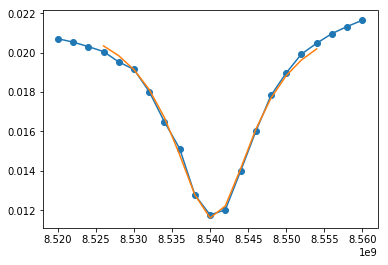

In [18]:
plt.plot(v0,marker = 'o')
plt.plot(v0_fit)

In [19]:
params = pd.DataFrame(index = s2_red.index.levels[0], columns = p_labels)

for i, time in enumerate(s2_red.index.levels[0]):
    dv = s2_red.loc[time]
    dvs.loc[time, :] =dv.values
    
    vs = v0 + dv
    vss.loc[time, :] =vs.values
    
#     epsilon = v0_p[-1]/100
#     p0 = [v0_p[-3],v0_p[-2],v0_p[-1]]
#     bounds = ([-np.inf,-np.inf,v0_p[-1] -epsilon ],[np.inf,np.inf,v0_p[-1] +epsilon])
    
    p0 = v0_p
    
    vs_fit, vs_p, vs_sl = fitsweep(vs, p0, bounds, window, fittype= fittype, p_labels= p_labels)
    vs_p = pd.Series(vs_p,index = p_labels)
        
    vs_fit = vs_fit(vs.index)
#     vs_fit = pd.Series(vs_fit(vs.index[vs_sl]), index = vs.index[vs_sl])
        
    fits.loc[time, :] =vs_fit
    
    params.loc[time] = vs_p

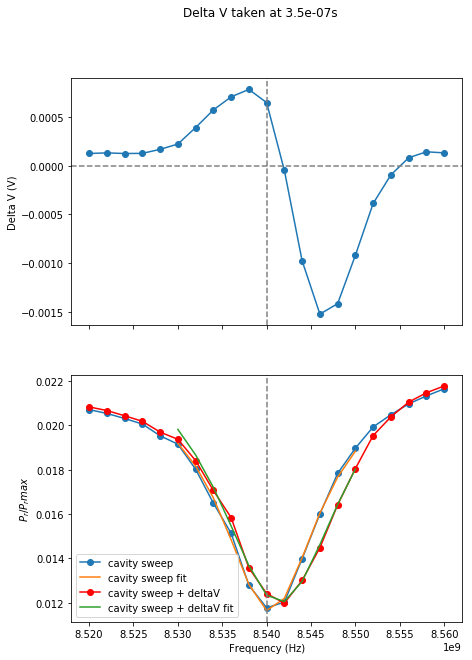

In [14]:
fittimes = fits.index.levels[0]
timesel = 350e-9
timesel = min(fittimes, key=lambda x:abs(x-timesel))

fig, axes = plt.subplots(2,1, figsize = (7,10), sharex = True)

axes[0].plot(dvs[timesel], marker = 'o')

axes[1].plot(v0, label = 'cavity sweep', marker = 'o')
axes[1].plot(v0_fit, label = 'cavity sweep fit')

axes[1].plot(vss[timesel], color = 'r', label = 'cavity sweep + deltaV' ,  marker = 'o')
axes[1].plot(fits.loc[timesel].iloc[vs_sl], label = 'cavity sweep + deltaV fit')

axes[1].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axhline(0, color = 'gray', linestyle = '--')

axes[0].set_ylabel('Delta V (V)')
axes[1].set_ylabel('$P_r/P_rmax$')
axes[1].set_xlabel('Frequency (Hz)')

# axes[1].set_xlim([8.525e9,8.545e9])
# axes[1].set_ylim([0.4,0.8])

fig.suptitle('Delta V taken at ' + str(timesel) + 's')

plt.legend()

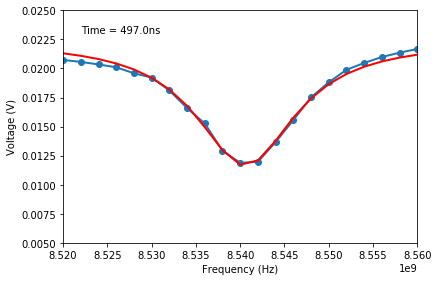

In [20]:
# First set up the figure, the axis, and the plot element we want to animate

timesel1 = 250e-9
timesel2 = 500e-9

fittimes = fits.index.levels[0]

idx1 = abs(fittimes - timesel1).argmin()
idx2 = abs(fittimes - timesel2).argmin()

RawData_Frames = vss.loc[fittimes[idx1]:fittimes[idx2], :]
RawData_Frames_fit = fits.loc[fittimes[idx1]:fittimes[idx2], :]
timeindex = fittimes[idx1:idx2]
interval = 50
xs = fits.index.levels[1]

fig = plt.figure()
ax = plt.axes(xlim=(xs[0], xs[-1]), ylim = (0.005,0.025))

line, = ax.plot([], [], lw=2, marker = 'o')
line_fit, = ax.plot([], [], lw=2, color = 'r')

time_template = 'Time = %.1fns'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

fig.tight_layout()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line_fit.set_data([], [])
    time_text.set_text('')
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Frequency (Hz)") 
    return line,line_fit

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xs, RawData_Frames.loc[timeindex[i]])
    line_fit.set_data(xs, RawData_Frames_fit.loc[timeindex[i]])
    time_text.set_text(time_template % int(timeindex[i]*1e9))
    return line, time_text



# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(timeindex), interval = interval, blit=True)


# TML(anim.to_html5_video())

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

anim

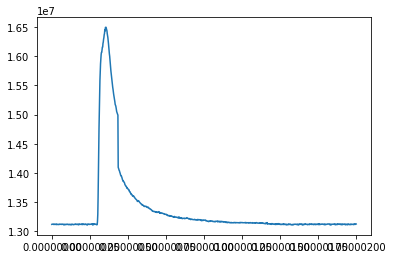

In [21]:
plt.plot(params['Q'])
# plt.plot(abs(deltaFWHM))
# plt.yscale('log')

In [198]:
v0_p['f0']

8540463077.994978

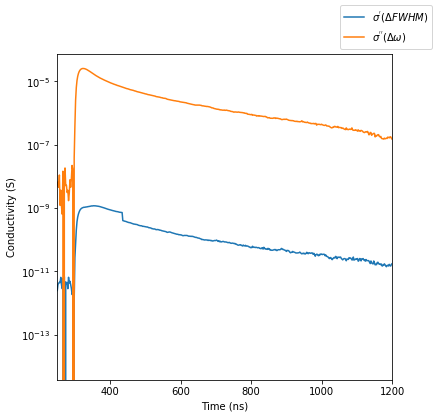

In [22]:

fig, axes = plt.subplots(1,1, figsize = (6,6), sharex = True)

e0 = 8.854e-12
F=1

deltaf = params['f0']- v0_p['f0']
deltaf = abs(deltaf)
sig_I = 2*deltaf*e0/F


# deltaR = params['R']- v0_p['R']
# sig_R = (1/K['KCs'])*(deltaR/v0_p['R'])
# sig_R = abs(sig_R)
# label = '$\sigma^{\'}(\Delta R)$'

deltaFWHM = v0_p['f0']*((1/params['Q'])- (1/v0_p['Q']))  
sig_R = -1*deltaFWHM*e0/F
label = '$\sigma^{\'}(\Delta FWHM)$'

    
axes.plot(sig_R, label = label)
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.set_xlim(250e-9,1200e-9)

fmt = exp_formatter(-9)
axes.xaxis.set_major_formatter(FuncFormatter(fmt.format_func))
axes.set_xlabel('Time (ns)')
# for ax in axes:
# axes.set_ylim([1e-8,1e-4])
fig.legend()